In [1]:
pip install stim

Note: you may need to restart the kernel to use updated packages.


In [10]:
import stim, random

import numpy  as np
n = 3
# GHZ
prep = stim.Circuit()
prep.append_operation("H", [0])
for i in range(1, n):
    prep.append_operation("CNOT", [0, i])

pairs = [(i,j) for i in range(n) for j in range(i+1,n)]
targets = [(i,j,p,q) for (i,j) in pairs for p in "XYZ" for q in "XYZ"]  # 全2-local
acc = {key: 0.0 for key in targets}

M = 100# 例
for _ in range(M):
    circ = stim.Circuit()
    circ += prep
    bases = []
    for q in range(n):
        b = random.choice("XYZ"); bases.append(b)
        if b == "X": circ.append_operation("H", [q])
        elif b == "Y": circ.append_operation("S_DAG", [q]); circ.append_operation("H", [q])
    circ.append_operation("M", list(range(n)))
    bits = circ.compile_sampler().sample(1)[0]
    # ±1 へ
    vals = {q: 1 - 2*bits[q] for q in range(n)}
    # 推定器更新
    for (i,j,p,q) in targets:
        if bases[i]==p and bases[j]==q:
            acc[(i,j,p,q)] += 9 * (vals[i]*vals[j])

# 推定値
est = {k: v/M for k,v in acc.items()}


In [ ]:

true_val = lambda P, Q: 1.0 if (P == 'Z' and Q == 'Z') else 0.0

# 真値との差の二乗（分散的誤差）
var_true = {}
for key, val in est.items():
    i, j, P, Q = key
    true = true_val(P, Q)
    var_true[key] = (val - true) ** 2

# 最大値と対応キー
max_key = max(var_true, key=var_true.get)
max_val = var_true[max_key]



最大分散 (評価値): 0.081
達成ペア (i,j,P,Q): (1, 2, 'X', 'Y')


M=    10  max |est-true|=5.3000e+00  key=(27, 47, 'Z', 'Z')   |est-true|/sqrt(M)=1.6760e+00
M=   100  max |est-true|=1.1700e+00  key=(27, 91, 'Y', 'X')   |est-true|/sqrt(M)=1.1700e-01
M=  1000  max |est-true|=4.0500e-01  key=(87, 88, 'X', 'Y')   |est-true|/sqrt(M)=1.2807e-02
M= 10000  max |est-true|=1.3140e-01  key=(31, 82, 'Y', 'Y')   |est-true|/sqrt(M)=1.3140e-03


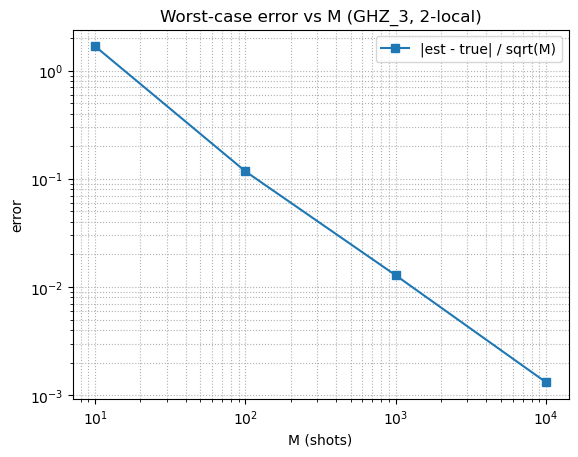

In [ ]:
# -*- coding: utf-8 -*-
import stim, random, numpy as np, math, csv
import matplotlib.pyplot as plt

# ---------- 設定 ----------
n = 100
M_list = [10, 100, 1000, 10000]   # 試したい M の一覧
seed = 42                                        # 乱数再現性
save_prefix = "estimates_M"                      # 出力CSVの接頭辞
# -------------------------

random.seed(seed)
np.random.seed(seed)

# GHZ(3) 準備回路
prep = stim.Circuit()
prep.append_operation("H", [0])
for i in range(1, n):
    prep.append_operation("CNOT", [0, i])

pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]
targets = [(i, j, p, q) for (i, j) in pairs for p in "XYZ" for q in "XYZ"]  # 全2-local

def true_val(P, Q):
    # GHZ_3 の二体相関: ZZ = 1, その他は 0
    return 1.0 if (P == 'Z' and Q == 'Z') else 0.0

def run_once(M):
    """M 回のショットから各 (i,j,P,Q) の推定値 est を返す。"""
    acc = {key: 0.0 for key in targets}
    for _ in range(M):
        circ = stim.Circuit()
        circ += prep
        bases = []
        for q in range(n):
            b = random.choice("XYZ")
            bases.append(b)
            if b == "X":
                circ.append_operation("H", [q])
            elif b == "Y":
                circ.append_operation("S_DAG", [q])
                circ.append_operation("H", [q])
        circ.append_operation("M", list(range(n)))
        bits = circ.compile_sampler().sample(1)[0]
        vals = {q: 1 - 2 * bits[q] for q in range(n)}  # {0,1} -> {+1,-1}

        # マッチした基底のみで不偏推定（確率 1/9 の補正として 9 倍）
        for (i, j, P, Q) in targets:
            if bases[i] == P and bases[j] == Q:
                acc[(i, j, P, Q)] += 9.0 * (vals[i] * vals[j])

    est = {k: v / M for k, v in acc.items()}
    return est

def save_est_csv(est, M, path_prefix="estimates_M"):
    """各 M の est を CSV 保存。"""
    fname = f"{path_prefix}{M}.csv"
    with open(fname, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["i", "j", "P", "Q", "est"])
        for (i, j, P, Q), v in sorted(est.items()):
            w.writerow([i, j, P, Q, v])
    return fname

# ここから実験ループ
worst_abs_err = []     # 各 M での max_{i,j,P,Q} |est - true|
se_like_metric = []    # ユーザ式: sqrt( (est-true)^2 / M ) = |est-true| / sqrt(M)
Ms = []

for M in M_list:
    est = run_once(M)
    _ = save_est_csv(est, M, save_prefix)

    # 誤差評価
    abs_errs = {}
    for key, val in est.items():
        _, _, P, Q = key
        t = true_val(P, Q)
        abs_errs[key] = abs(val - t)

    # 最大誤差
    max_key = max(abs_errs, key=abs_errs.get)
    max_abs = abs_errs[max_key]

    # 「分散的誤差」っぽい指標（依頼の式に忠実に）
    # 元コード: max_val = (val - true)^2; print(sqrt(max_val/M))
    se_like = max_abs / math.sqrt(M)

    Ms.append(M)
    worst_abs_err.append(max_abs)
    se_like_metric.append(se_like)

    print(f"M={M:6d}  max |est-true|={max_abs:.4e}  key={max_key}   |est-true|/sqrt(M)={se_like:.4e}")

# グラフ描画（色指定なし、単独軸、サブプロットなし）
plt.figure()
# plt.loglog(Ms, worst_abs_err, marker="o", label="max |est - true|")
plt.loglog(Ms, se_like_metric, marker="s", label="|est - true| / sqrt(M)")
plt.xlabel("M (shots)")
plt.ylabel("error")
plt.title("Worst-case error vs M (GHZ_3, 2-local)")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()


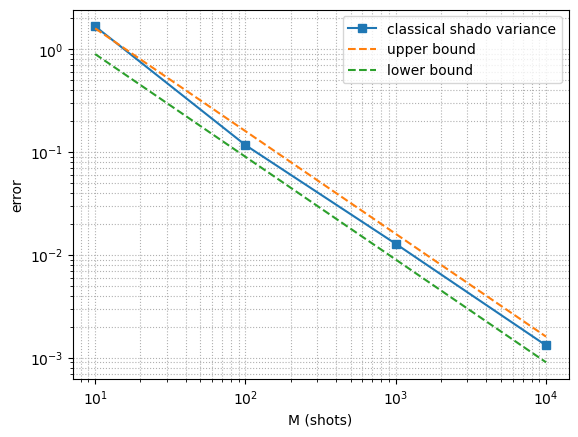

In [26]:
plt.figure()
# plt.loglog(Ms, worst_abs_err, marker="o", label="max |est - true|")

k = 2 
M_arr = np.array(Ms, dtype=float)

theory_upper = 4.0** k / M_arr  
theory_lower = 3.0** k / M_arr                 # 単一可観測量のスケール

plt.loglog(Ms, se_like_metric, marker="s", label="classical shado variance")
plt.xlabel("M (shots)")
plt.ylabel("error")
# plt.title("Worst-case error vs M (GHZ_3, 2-local)")

plt.grid(True, which="both", ls=":")

plt.loglog(Ms, theory_upper, linestyle="--", label="upper bound")
plt.loglog(Ms, theory_lower, linestyle="--", label="lower bound")
plt.legend()
plt.savefig("n-50-k-local-classical.png", dpi=300, bbox_inches="tight")


In [24]:
k = 2
x = np.log(M_arr)
y = np.log(se_like_metric)

# 理論的には y ≈ -x + k*log(a)
# → log(a) = (intercept) / k
slope, intercept = np.polyfit(x, y, 1)
a_est = np.exp(intercept / k)

print(f"log–log fit slope = {slope:.3f}")
print(f"推定 a ≈ {a_est:.4f}")


log–log fit slope = -1.028
推定 a ≈ 3.9768


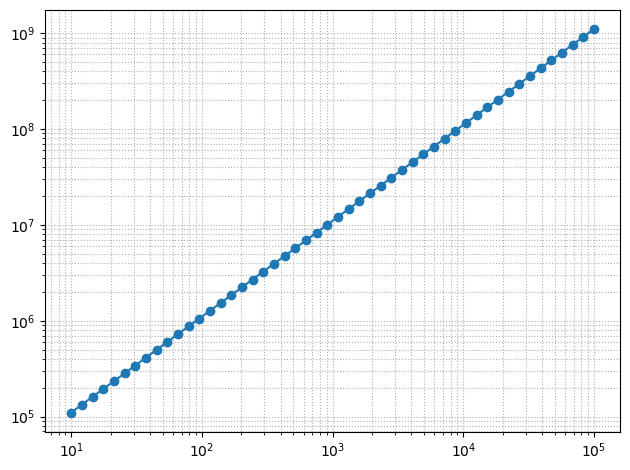

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 固定パラメータ
n = 50                  # ← 固定したい qubit 数をここで設定
M_list = np.logspace(1, 5, 50)     # M = 10〜100000（logスケール）

# 2-local observable の数
N_obs = 9 * n * (n - 1) / 2

# 総ショット数
M_total = N_obs * M_list

# プロット
plt.figure()
plt.loglog(M_list, M_total, marker="o")
plt.loglog(se_like_metric,  marker="s", label="classical shado variance")
plt.xlabel("M (shots)")
plt.ylabel("error")
# plt.title("Worst-case error vs M (GHZ_3, 2-local)")

plt.grid(True, which="both", ls=":")

plt.loglog(Ms, theory_upper, linestyle="--", label="upper bound")
plt.loglog(Ms, theory_lower, linestyle="--", label="lower bound")
# plt.xlabel("M (shots per observable)")
# plt.ylabel("Total shots required")
# plt.title(f"Total shots vs M (n = {n}, 2-local observables)")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


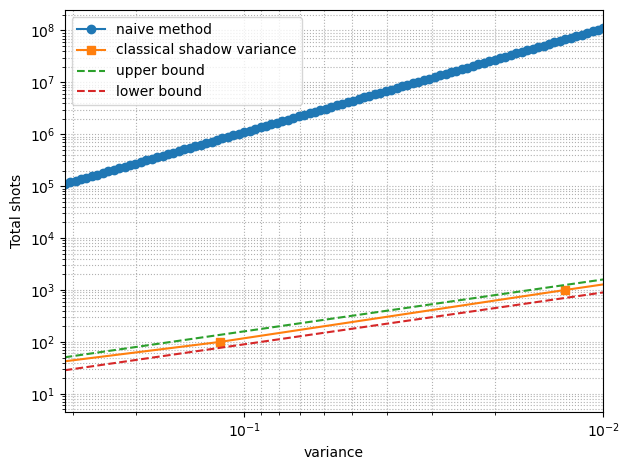

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 固定パラメータ
n = 50                               # 固定する量子ビット数
N_obs = 9 * n * (n - 1) / 2          # 2-local observable の数

# 誤差の範囲（例: 0.01〜0.3）
error_list = np.logspace(-2, -0.5, 100)

# 総ショット数 = N_obs / error^2
M_total = N_obs / (error_list ** 2)

# プロット
plt.figure()
plt.loglog(error_list, M_total, marker="o", label="naive method")
plt.loglog(se_like_metric, Ms, marker="s", label="classical shadow variance")
# plt.xlabel (shots)")
# plt.ylabel("error")
# # plt.title("Worst-case error vs M (GHZ_3, 2-local)")

plt.grid(True, which="both", ls=":")

plt.loglog(theory_upper, Ms, linestyle="--", label="upper bound")
plt.loglog(theory_lower, Ms, linestyle="--", label="lower bound")

plt.xlabel("variance")
plt.ylabel("Total shots")
plt.legend()
# plt.title(f"Total shots vs Error (n = {n}, 2-local observables)")

plt.xlim(max(error_list), min(error_list))
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


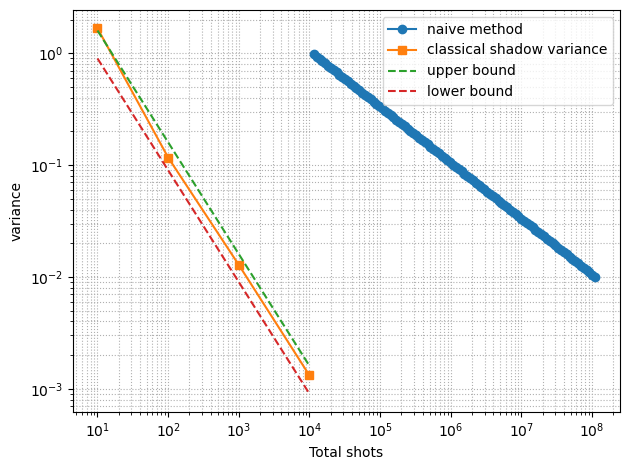

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 固定パラメータ
n = 50                              # 固定する量子ビット数
N_obs = 9 * n * (n - 1) / 2          # 2-local observable の数

# 誤差の範囲（例: 0.01〜0.3）
error_list = np.logspace(-2, -0.01, 100)

# 総ショット数 = N_obs / error^2
M_total = N_obs / (error_list ** 2)

# --- 理論線や実験データ（例として空配列に） ---
# これらはあなたの環境で定義済みの変数をそのまま使う想定
# se_like_metric, Ms, theory_upper, theory_lower が既に定義されているならこのままでOK
# 未定義ならコメントアウトしても動作します
# se_like_metric = ...
# Ms = ...
# theory_upper = ...
# theory_lower = ...

# プロット
plt.figure()

# 横軸を total shots、縦軸を error に
plt.loglog(M_total, error_list, marker="o", label="naive method")

# 実験データや理論線を追加
plt.loglog(Ms, se_like_metric, marker="s", label="classical shadow variance")
plt.loglog(Ms, theory_upper, linestyle="--", label="upper bound")
plt.loglog(Ms, theory_lower, linestyle="--", label="lower bound")

plt.xlabel("Total shots")
plt.ylabel("variance")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()
